In [4]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 375.8 kB/s eta 0:06:39
   ---------------------------------------- 0.1/150.0 MB 375.8 kB/s eta 0:06:39
   ---------------------------------------- 0.1/150.0 MB 375.8 kB/s eta 0:06:39
   ---------------------------------------- 0.1/150.0 MB 375.8 kB/s eta 0:06:39
   ---------------------------------------- 0.2/150.0 MB 378.3 kB/s eta 0:06:36
   ---------------------------------------- 0.2/150.0 MB 474.7 kB/s eta 0:05:16
   ---------------------------------------- 0.2/150.0 MB 474.7 kB/s eta 0:05:16
   ---------------------------------------- 0.2/150.0 MB 474.7 kB/s eta 0:05:16
   --

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)


In [7]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [10]:
data = pd.read_csv("loan_data (1).csv")

In [14]:
data.info()

data.describe(include='all')

data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

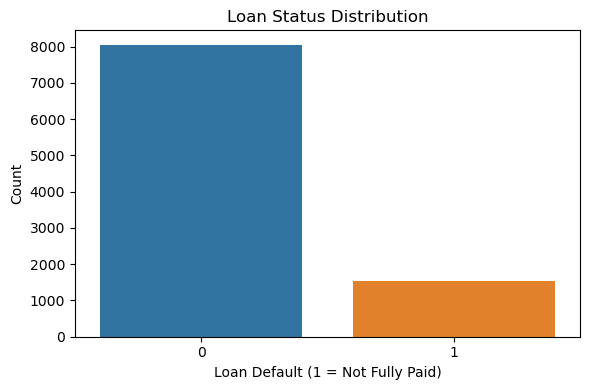

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='not.fully.paid')
plt.title("Loan Status Distribution")
plt.xlabel("Loan Default (1 = Not Fully Paid)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

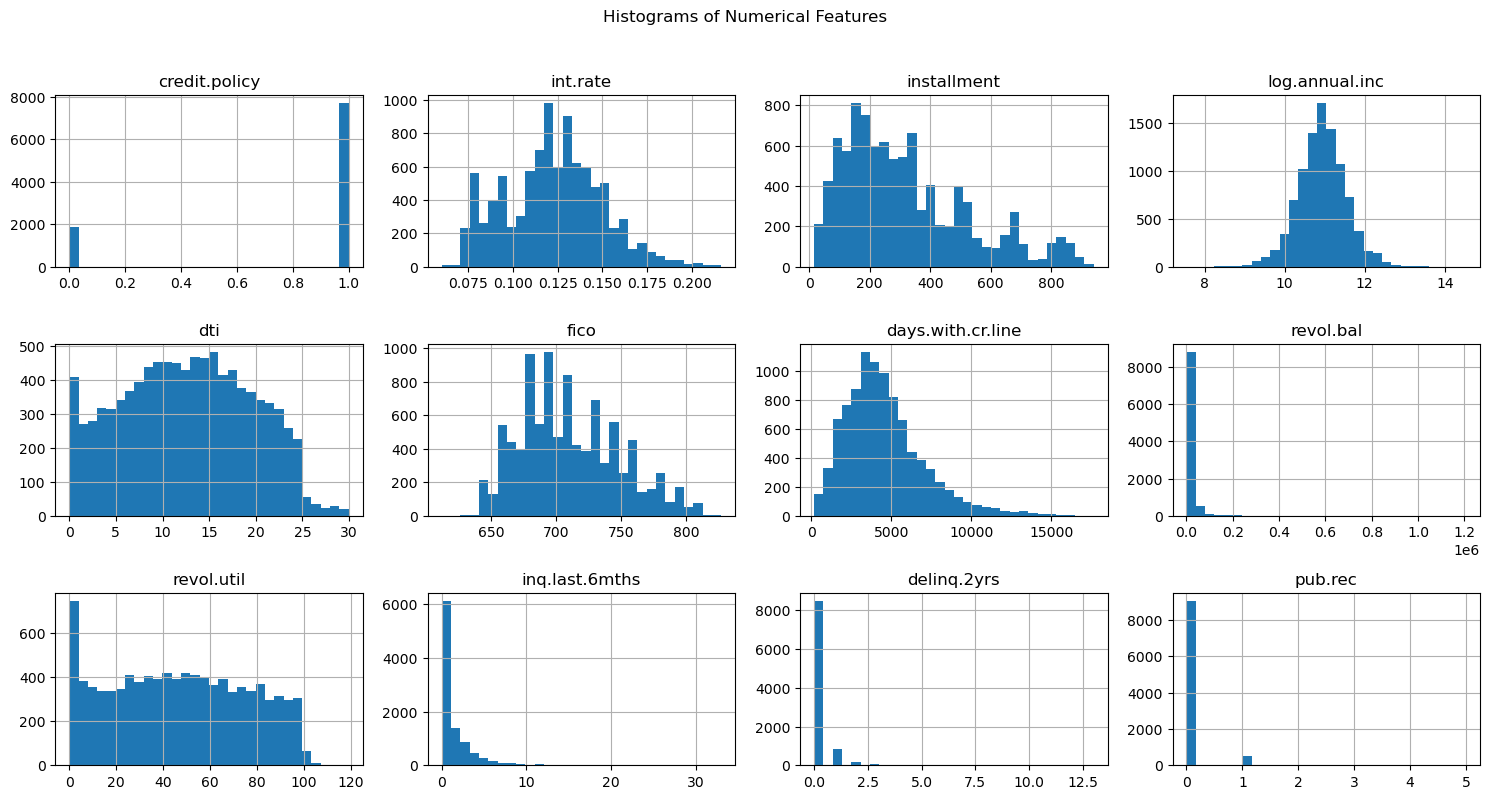

In [17]:
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.drop('not.fully.paid')
data[numerical_cols].hist(bins=30, figsize=(15, 10), layout=(4, 4))
plt.suptitle("Histograms of Numerical Features", y=1.02)
plt.tight_layout()
plt.show()

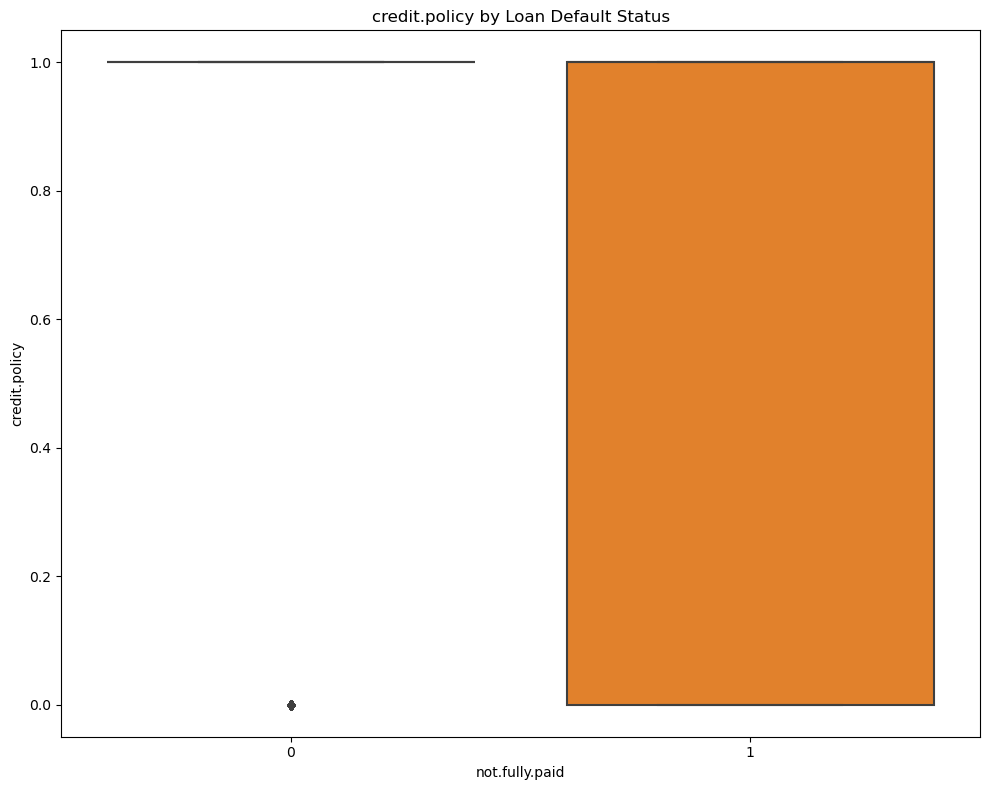

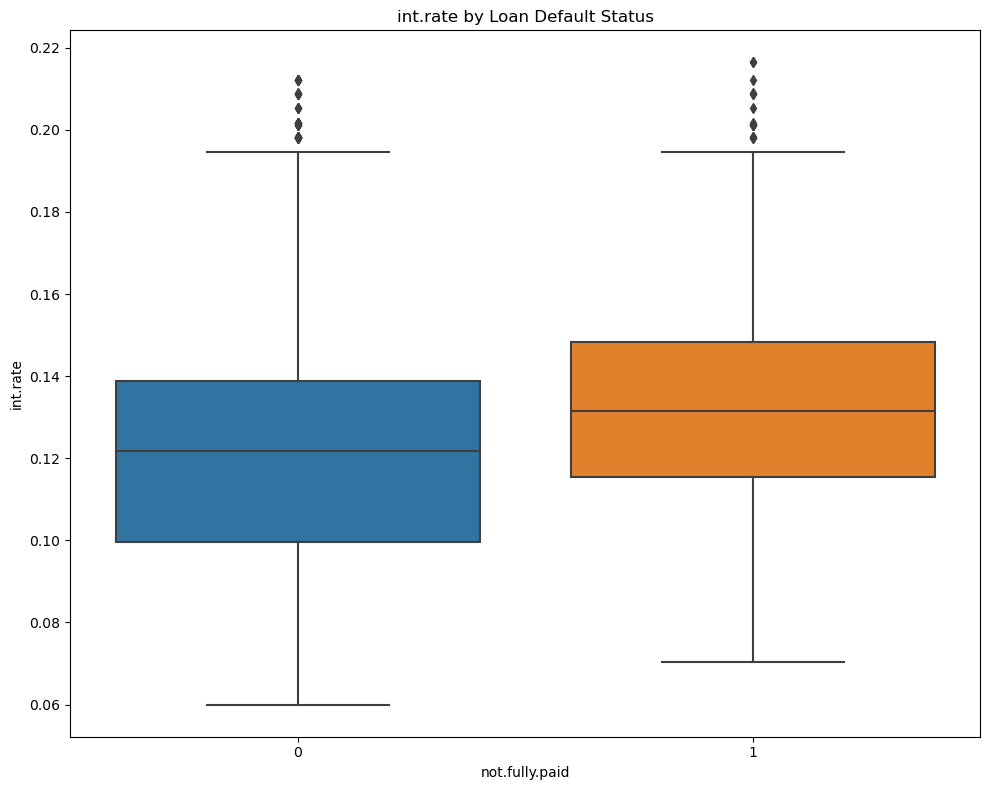

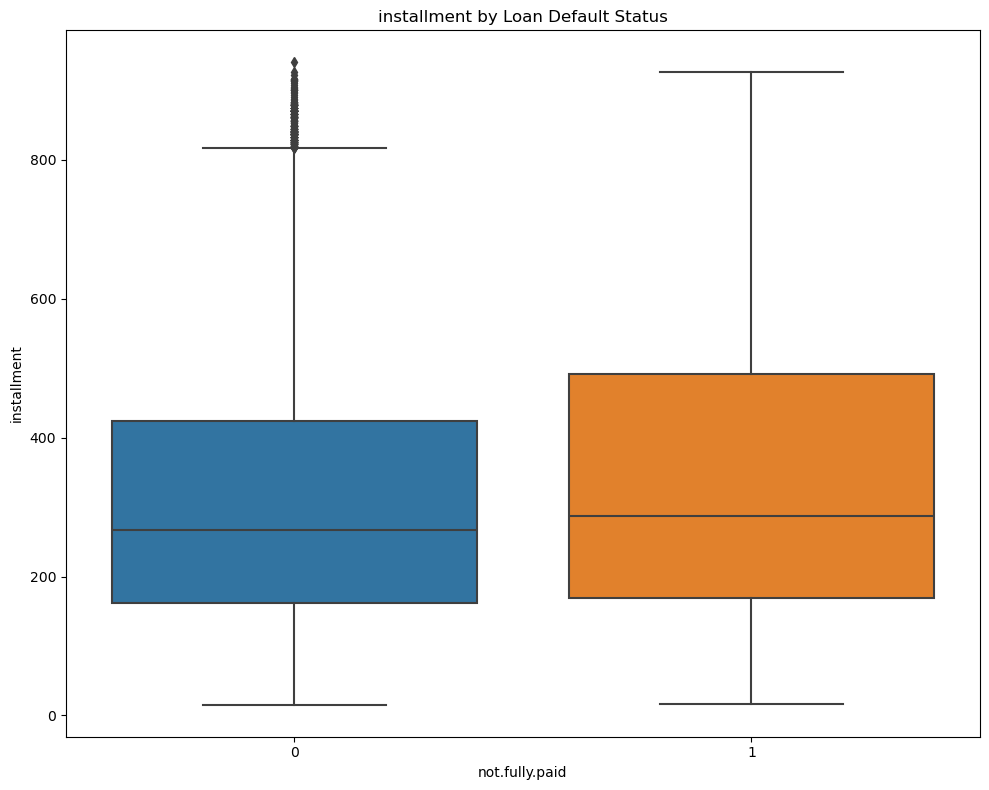

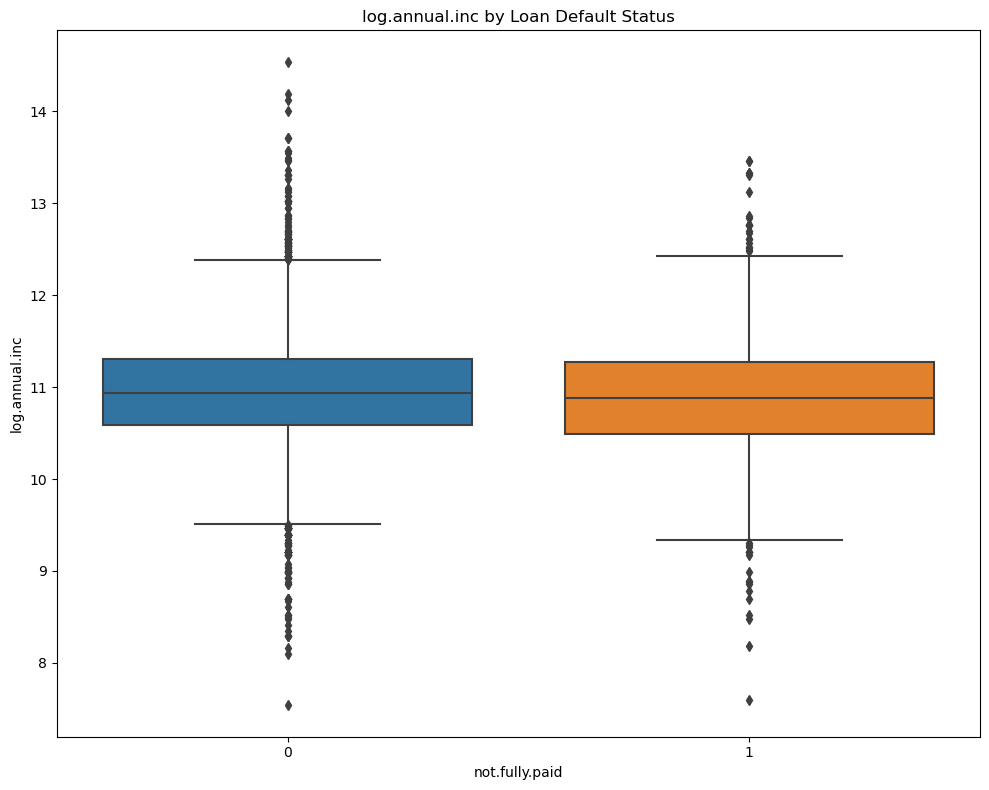

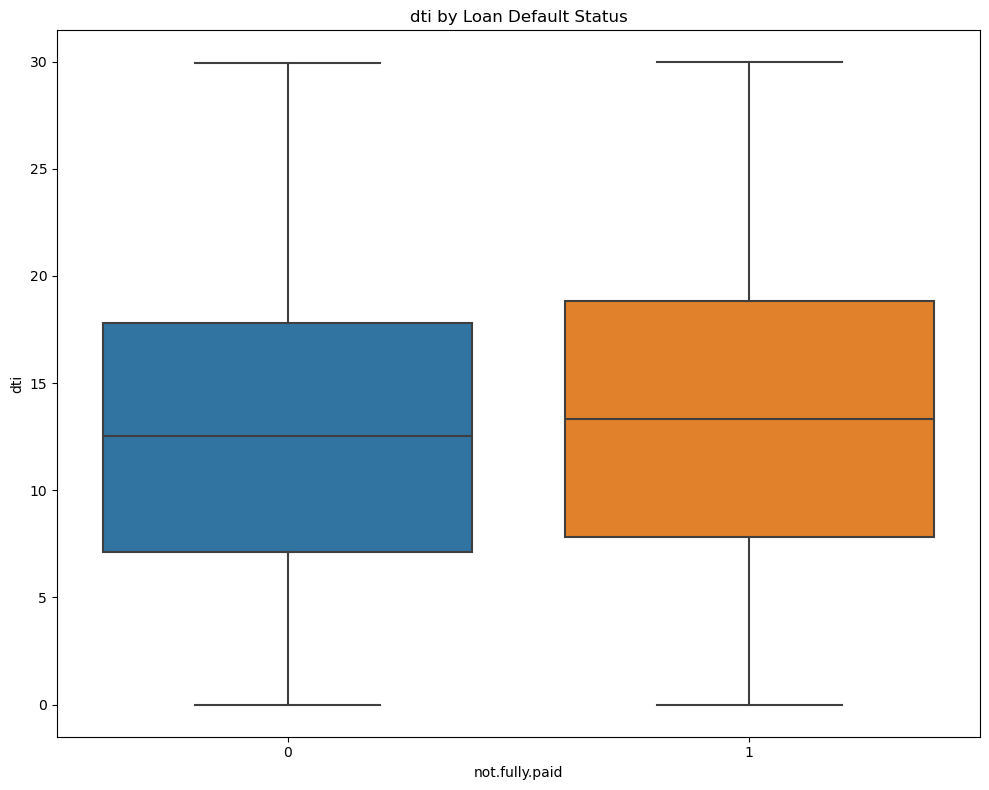

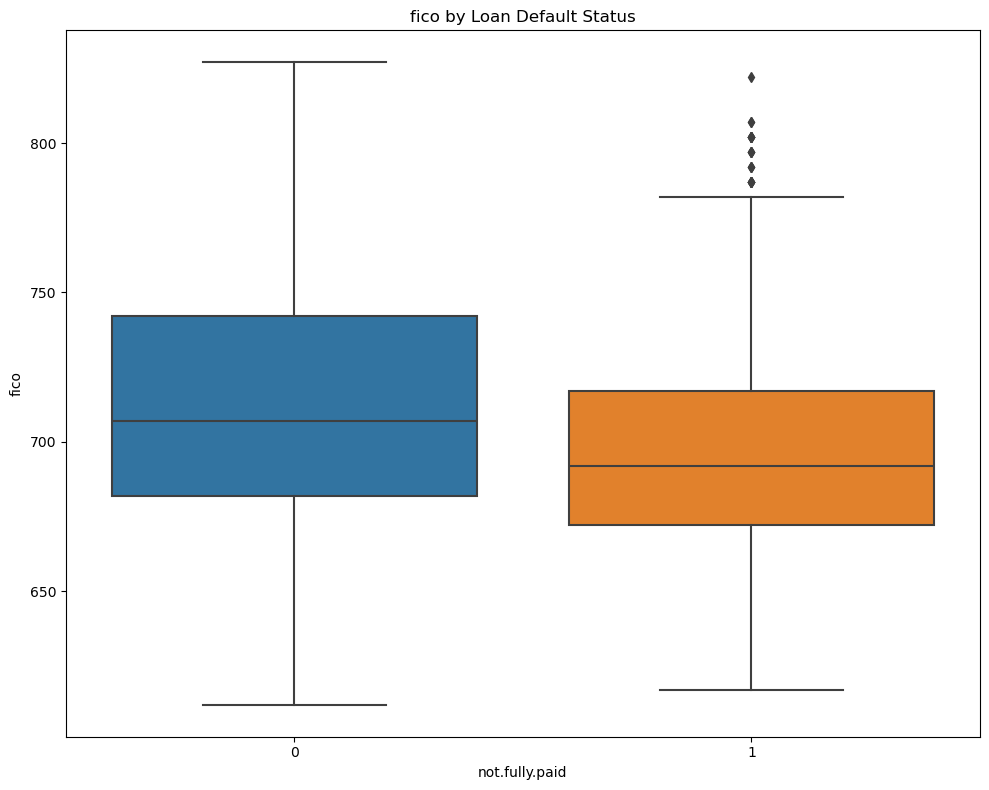

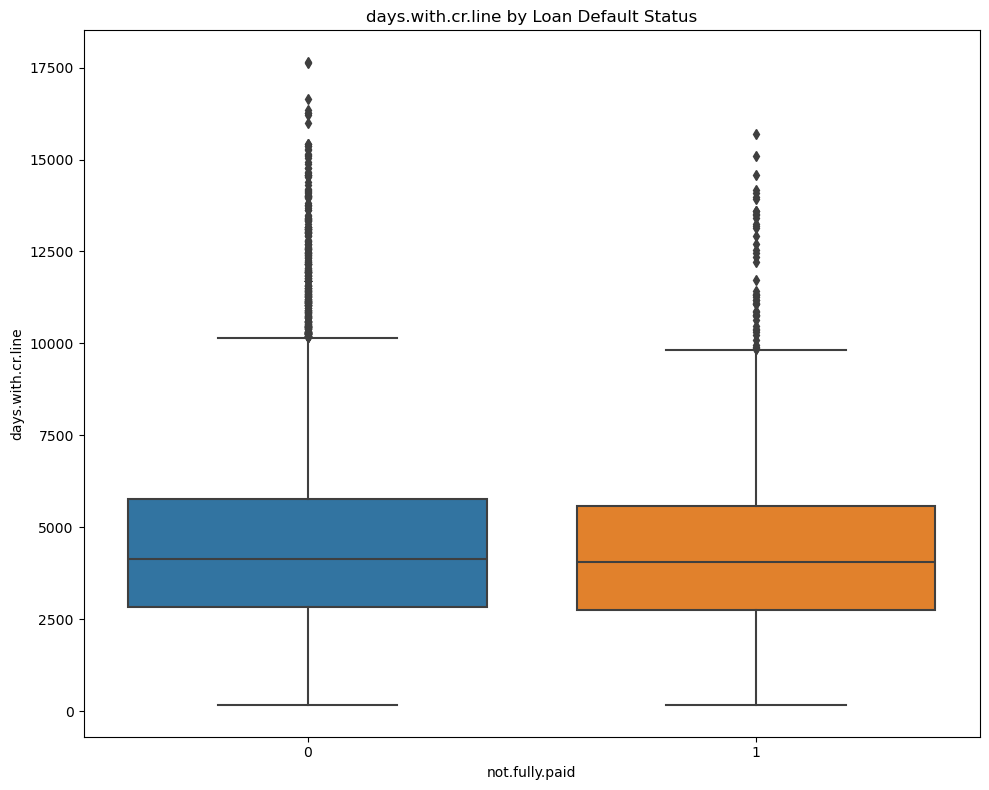

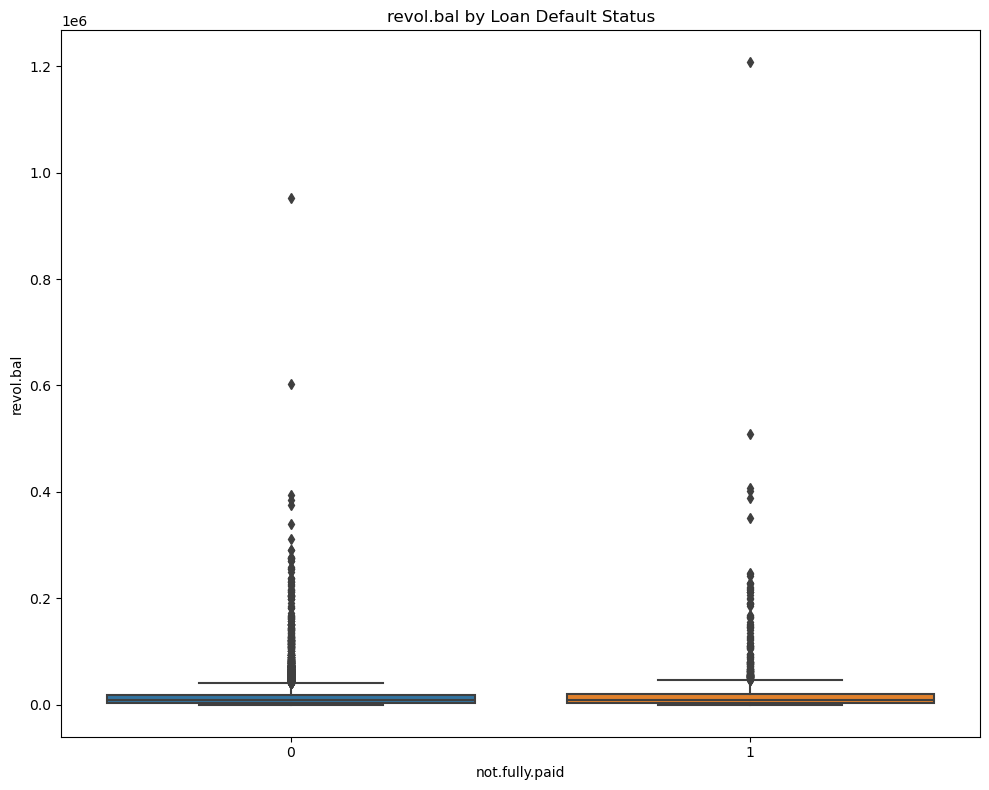

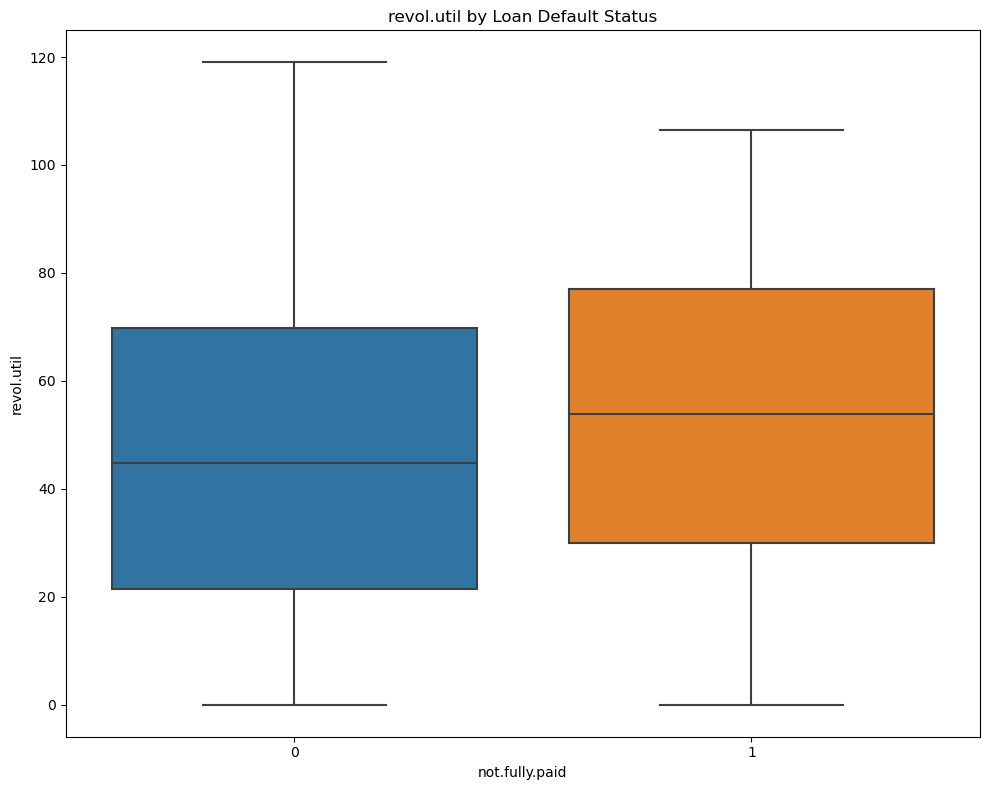

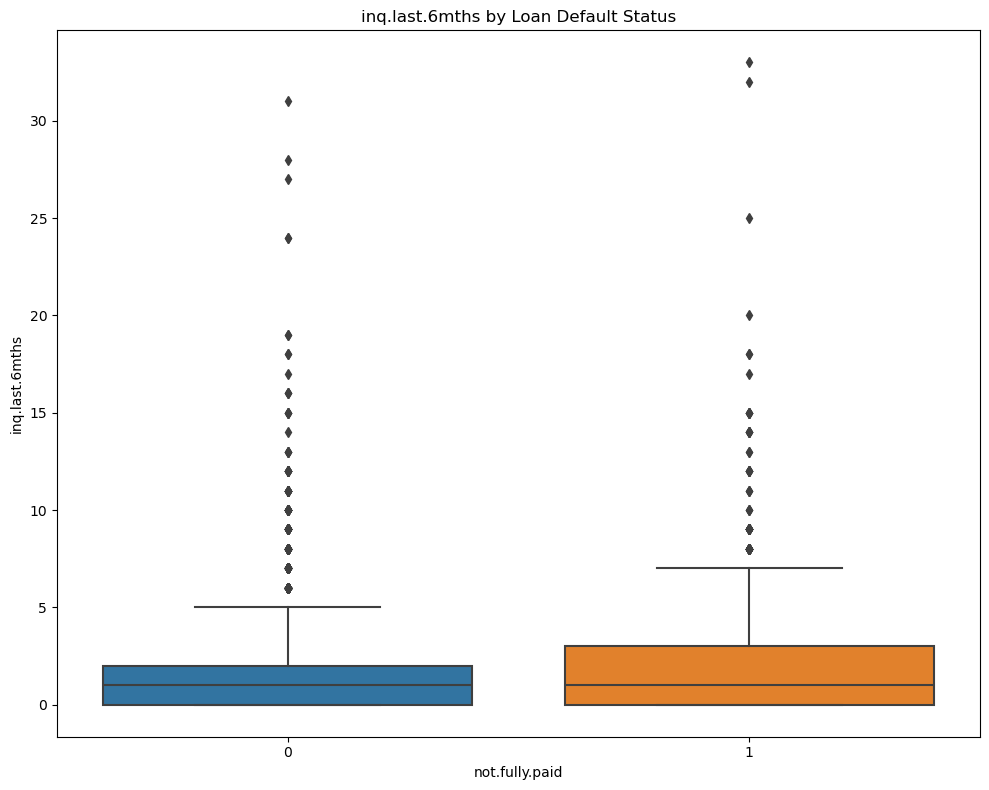

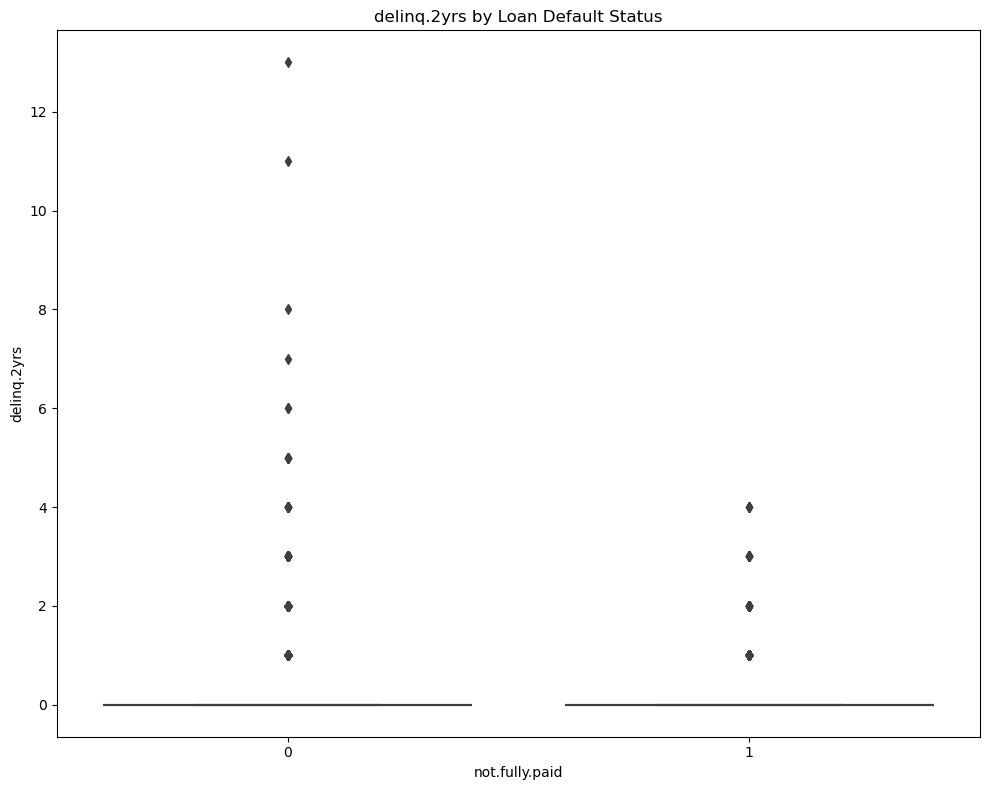

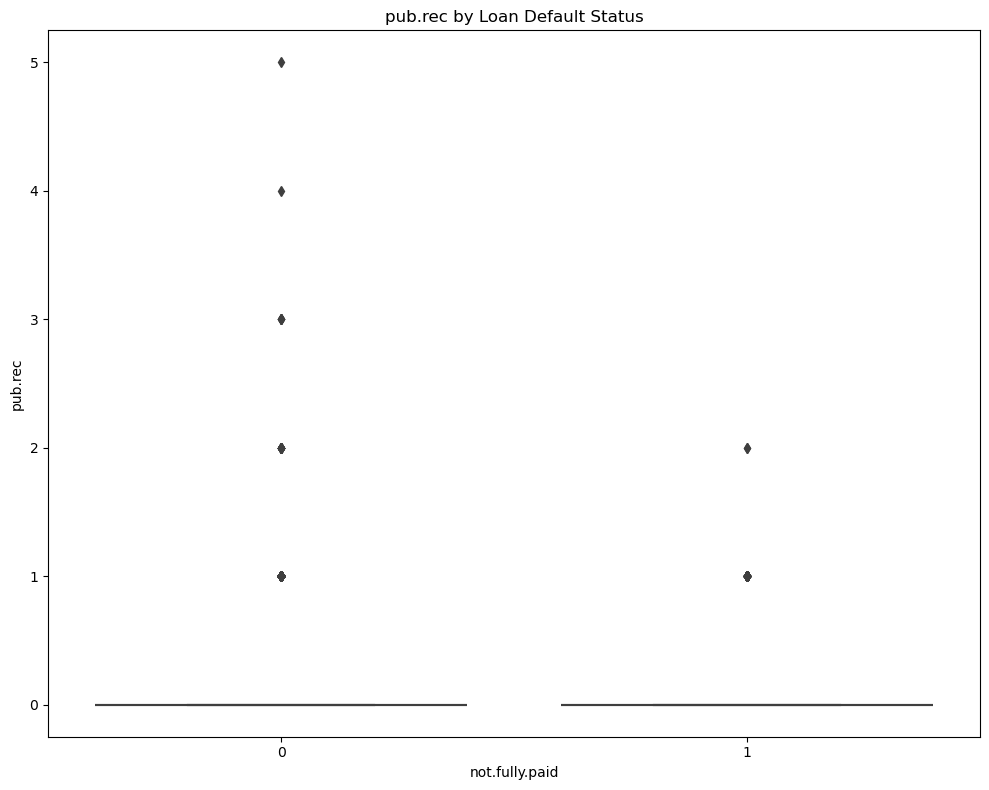

In [20]:
for col in numerical_cols:
    plt.figure(figsize=(10, 8))
    sns.boxplot(x='not.fully.paid', y=col, data=data)
    plt.title(f"{col} by Loan Default Status")
    plt.tight_layout()
    plt.show()

AttributeError: 'numpy.int64' object has no attribute 'startswith'

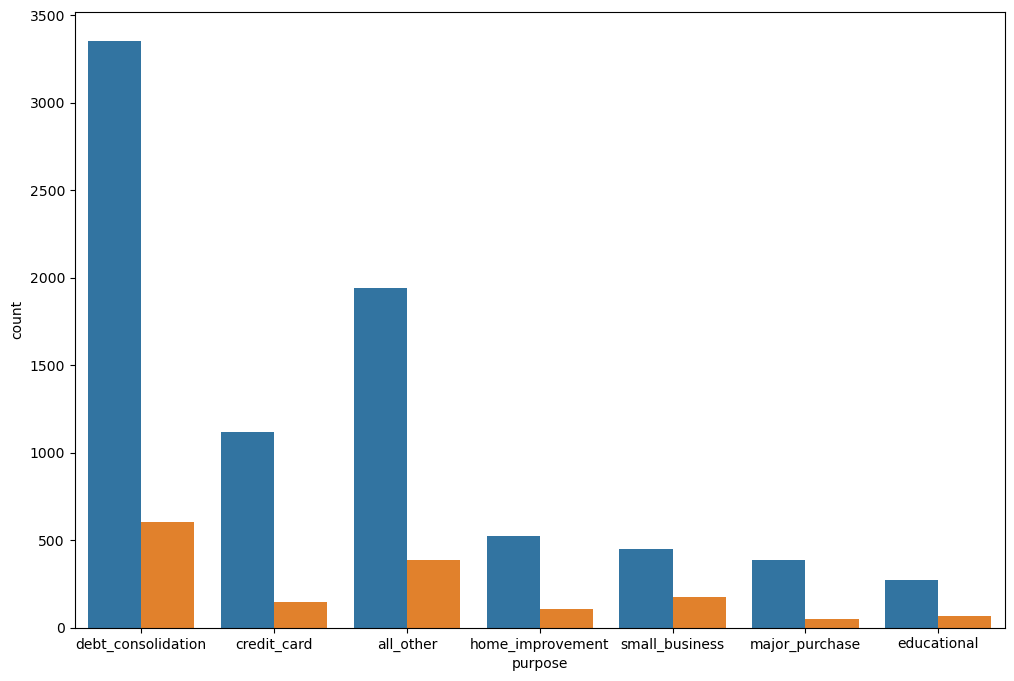

In [22]:
categorical_cols = ['purpose']
for col in categorical_cols:
    plt.figure(figsize=(12, 8))
    sns.countplot(data=data, x=col, hue='not.fully.paid')
    plt.title(f"{col} vs Loan Default")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

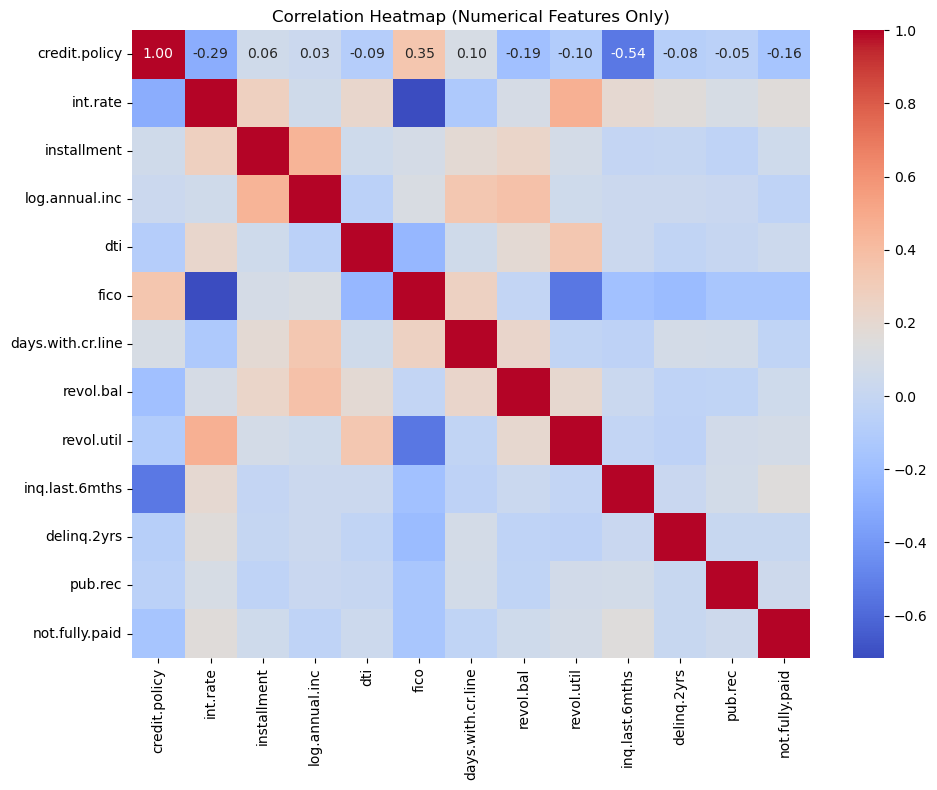

In [25]:
numeric_data = data.select_dtypes(include=["int64", "float64"])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features Only)")
plt.tight_layout()
plt.show()


In [26]:
target = "not.fully.paid"
y = data[target]
X = data.drop(columns=[target])

categorical_cols = ["purpose"]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

In [27]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
])

In [28]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=5, random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=SEED),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.1, max_depth=4, random_state=SEED),
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=SEED),
    "CatBoost": CatBoostClassifier(iterations=100, learning_rate=0.1, depth=4, verbose=0, random_state=SEED)
}

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=SEED)


In [47]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [48]:
auc_scores = {}
results_df = pd.DataFrame(columns=["Model", "Precision", "Recall", "F1-Score", "AUC"])

def evaluate_model(name, model):
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC Score: {auc:.4f}")

    # Cross-Validation AUC
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
    print(f"Cross-Validated AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    auc_scores[name] = auc

    report = classification_report(y_test, y_pred, output_dict=True)
    results_df.loc[len(results_df)] = [
        name,
        report["1"]["precision"],
        report["1"]["recall"],
        report["1"]["f1-score"],
        auc
    ]

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2012
           1       0.47      0.04      0.07       383

    accuracy                           0.84      2395
   macro avg       0.66      0.51      0.49      2395
weighted avg       0.78      0.84      0.78      2395

AUC Score: 0.6759
Cross-Validated AUC: 0.6800 ± 0.0027


<Figure size 500x400 with 0 Axes>

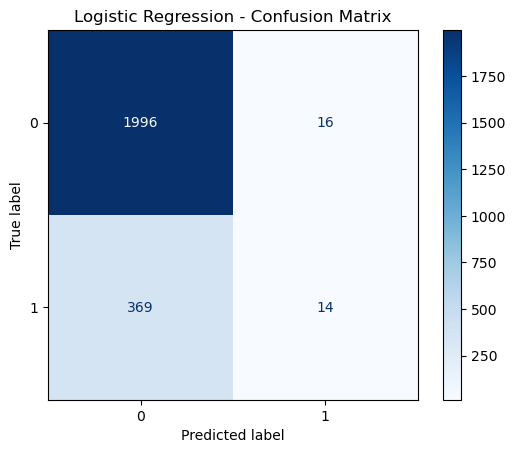

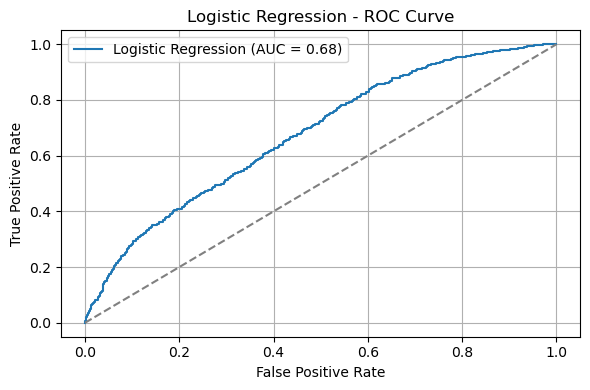


=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2012
           1       0.41      0.03      0.05       383

    accuracy                           0.84      2395
   macro avg       0.63      0.51      0.48      2395
weighted avg       0.77      0.84      0.77      2395

AUC Score: 0.6418
Cross-Validated AUC: 0.6368 ± 0.0095


<Figure size 500x400 with 0 Axes>

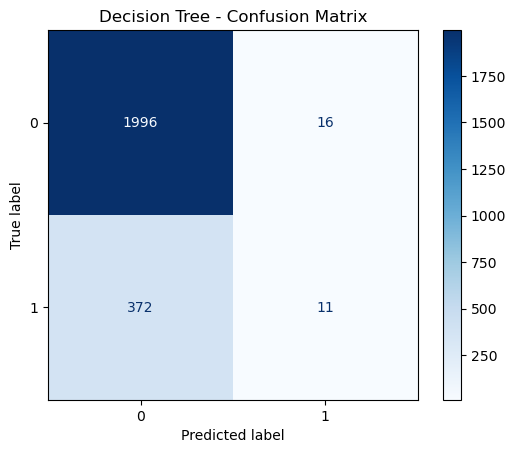

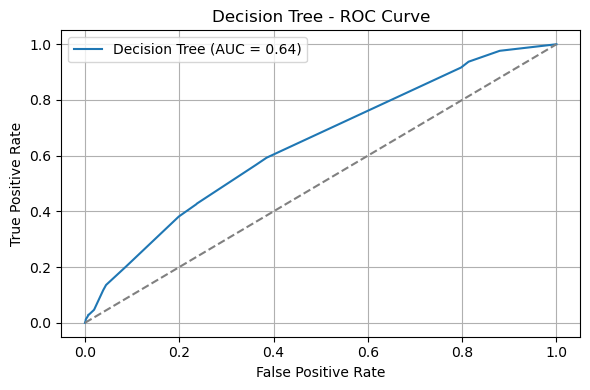


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2012
           1       0.00      0.00      0.00       383

    accuracy                           0.84      2395
   macro avg       0.42      0.50      0.46      2395
weighted avg       0.71      0.84      0.77      2395

AUC Score: 0.6705


C:\Users\farma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-Validated AUC: 0.6710 ± 0.0096


C:\Users\farma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 500x400 with 0 Axes>

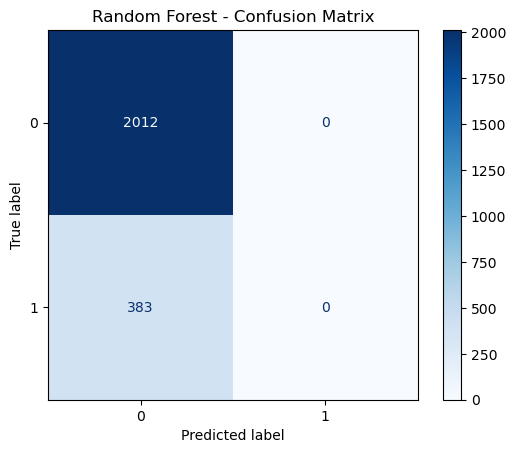

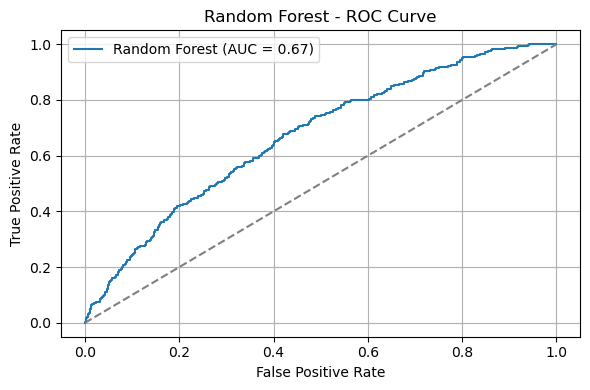


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2012
           1       0.38      0.04      0.08       383

    accuracy                           0.84      2395
   macro avg       0.61      0.51      0.49      2395
weighted avg       0.77      0.84      0.78      2395

AUC Score: 0.6543
Cross-Validated AUC: 0.6619 ± 0.0105


<Figure size 500x400 with 0 Axes>

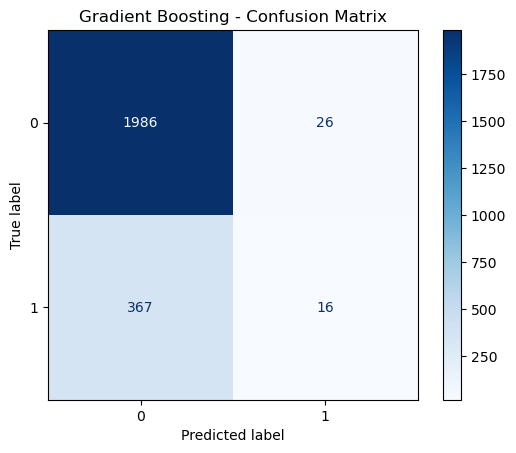

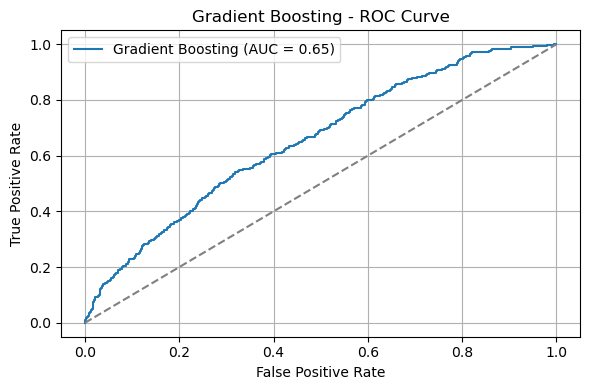

C:\Users\farma\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:14:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2012
           1       0.32      0.02      0.04       383

    accuracy                           0.84      2395
   macro avg       0.58      0.51      0.47      2395
weighted avg       0.76      0.84      0.77      2395

AUC Score: 0.6509


C:\Users\farma\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:14:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\farma\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:14:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\farma\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:14:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\farma\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:14:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

Cross-Validated AUC: 0.6652 ± 0.0131


<Figure size 500x400 with 0 Axes>

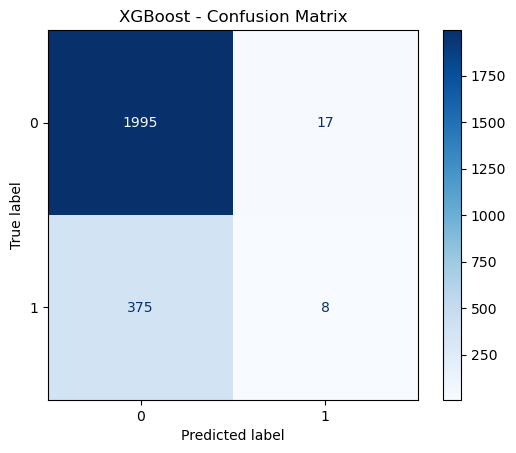

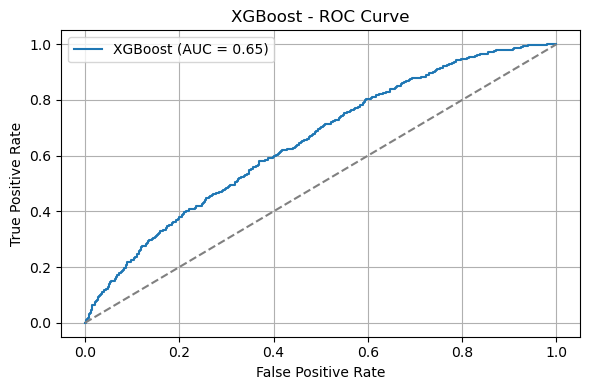

[LightGBM] [Info] Number of positive: 1150, number of negative: 6033
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 7183, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160100 -> initscore=-1.657482
[LightGBM] [Info] Start training from score -1.657482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

<Figure size 500x400 with 0 Axes>

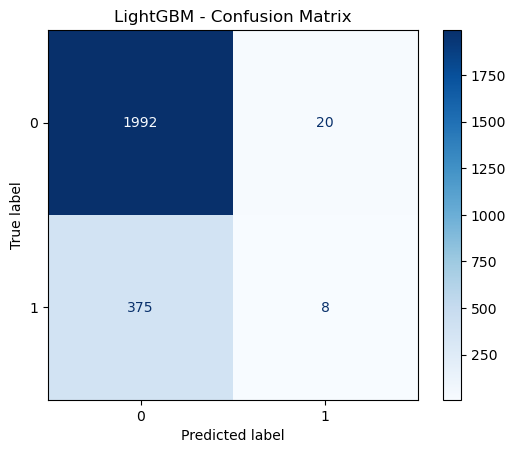

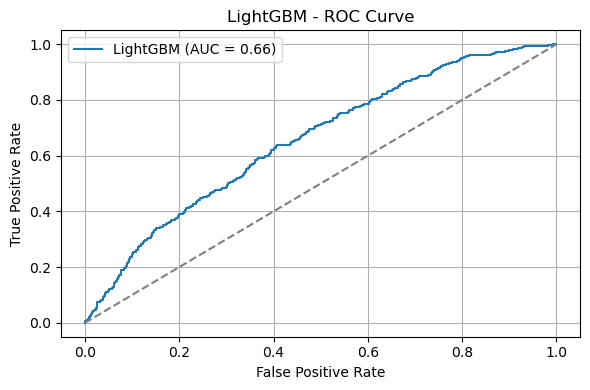


=== CatBoost ===
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2012
           1       0.33      0.01      0.01       383

    accuracy                           0.84      2395
   macro avg       0.59      0.50      0.46      2395
weighted avg       0.76      0.84      0.77      2395

AUC Score: 0.6662
Cross-Validated AUC: 0.6737 ± 0.0072


<Figure size 500x400 with 0 Axes>

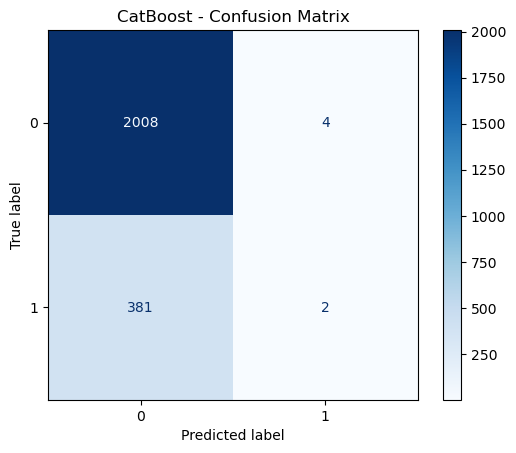

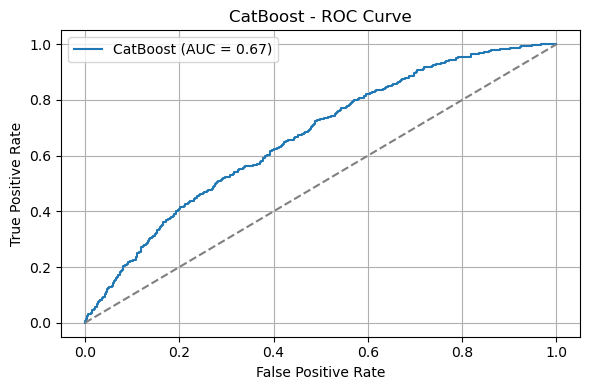

In [49]:
for name, model in models.items():
    evaluate_model(name, model)


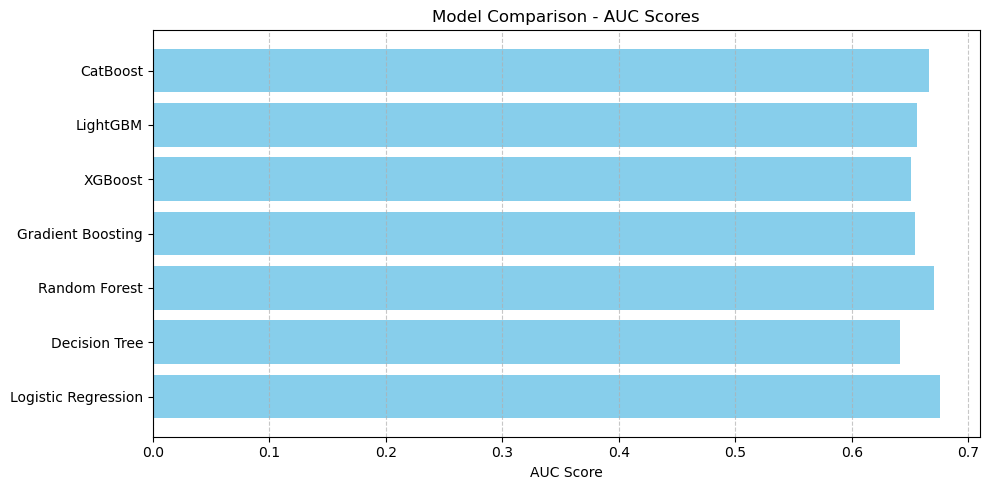

In [50]:
plt.figure(figsize=(10, 5))
plt.barh(list(auc_scores.keys()), list(auc_scores.values()), color='skyblue')
plt.xlabel("AUC Score")
plt.title("Model Comparison - AUC Scores")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()